In [1]:
!pip install statsmodels

In [2]:
!pip install pmdarima

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
import pmdarima as pm
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.arima_model import ARIMA


### Box Jenkins Method (details):

1. Apply transformations to make time series stationary (detrending, transformations, differencing).
2. If differencing, keep track of order d of differencing. Don't overdifference!
3. Confirm stationarity (visually, ACF, ADF test)
4. Plot ACF/PACF, identify likely AR and MA orders p, q.
5. Fit original (non-differenced) data with ARIMA model of order p, d, q
6. Try a few other values around these orders
7. Of all models with similarly low AIC, pick the least complex one
8. Inspect residuals: If ACF and PACF show white noise (no signal left)➔ You are done.
9. Otherwise ➔ Iterate (Try other transformations, change order of differencing, Add/Remove MA/AR terms)
10. Compare with Auto-ARIMA output trace


In [4]:
# Reading Data
data = pd.read_excel('../raw_data/weekly_data_clean.xlsx', engine='openpyxl')

In [5]:
data

,Unnamed: 0,date_issue,total_amount_claims
0,0,2018-09-03,16683
1,1,2018-09-10,201774
2,2,2018-09-17,263661
3,3,2018-09-24,799703
4,4,2018-10-01,900305
...,...,...,...
127,127,2021-02-08,1949930
128,128,2021-02-15,1725225
129,129,2021-02-22,2232202
130,130,2021-03-01,2666662


In [6]:
# Dropping extra index column
data = data.drop(columns= 'Unnamed: 0')

In [7]:
data.isnull().sum()

date_issue             0
total_amount_claims    0
dtype: int64

In [8]:
# Check types and lenght
data.dtypes, len(data)

(date_issue             datetime64[ns]
 total_amount_claims             int64
 dtype: object,
 132)

<AxesSubplot:xlabel='date_issue'>

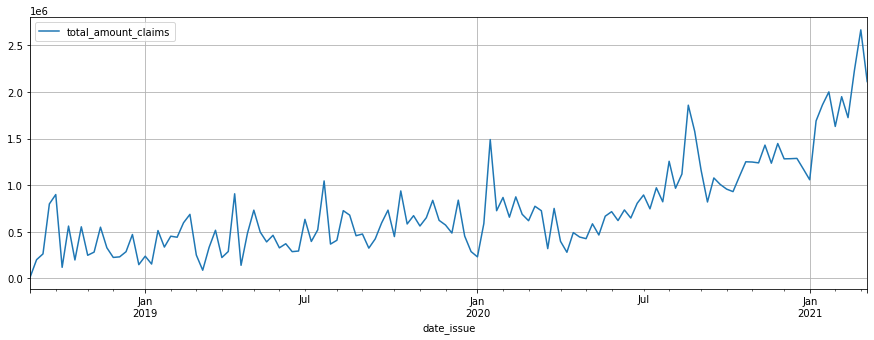

In [9]:
# Setting index as date, to plot time series
data_di = data.set_index('date_issue')

#Plotting
data_di.plot(grid=True, figsize=(15,5))

In [10]:
data_di.head()

,total_amount_claims
date_issue,
2018-09-03,16683
2018-09-10,201774
2018-09-17,263661
2018-09-24,799703
2018-10-01,900305


#### 1. Apply transformations to make time series stationary (detrending, transformations, differencing).

<AxesSubplot:xlabel='date_issue'>

<Figure size 1440x720 with 0 Axes>

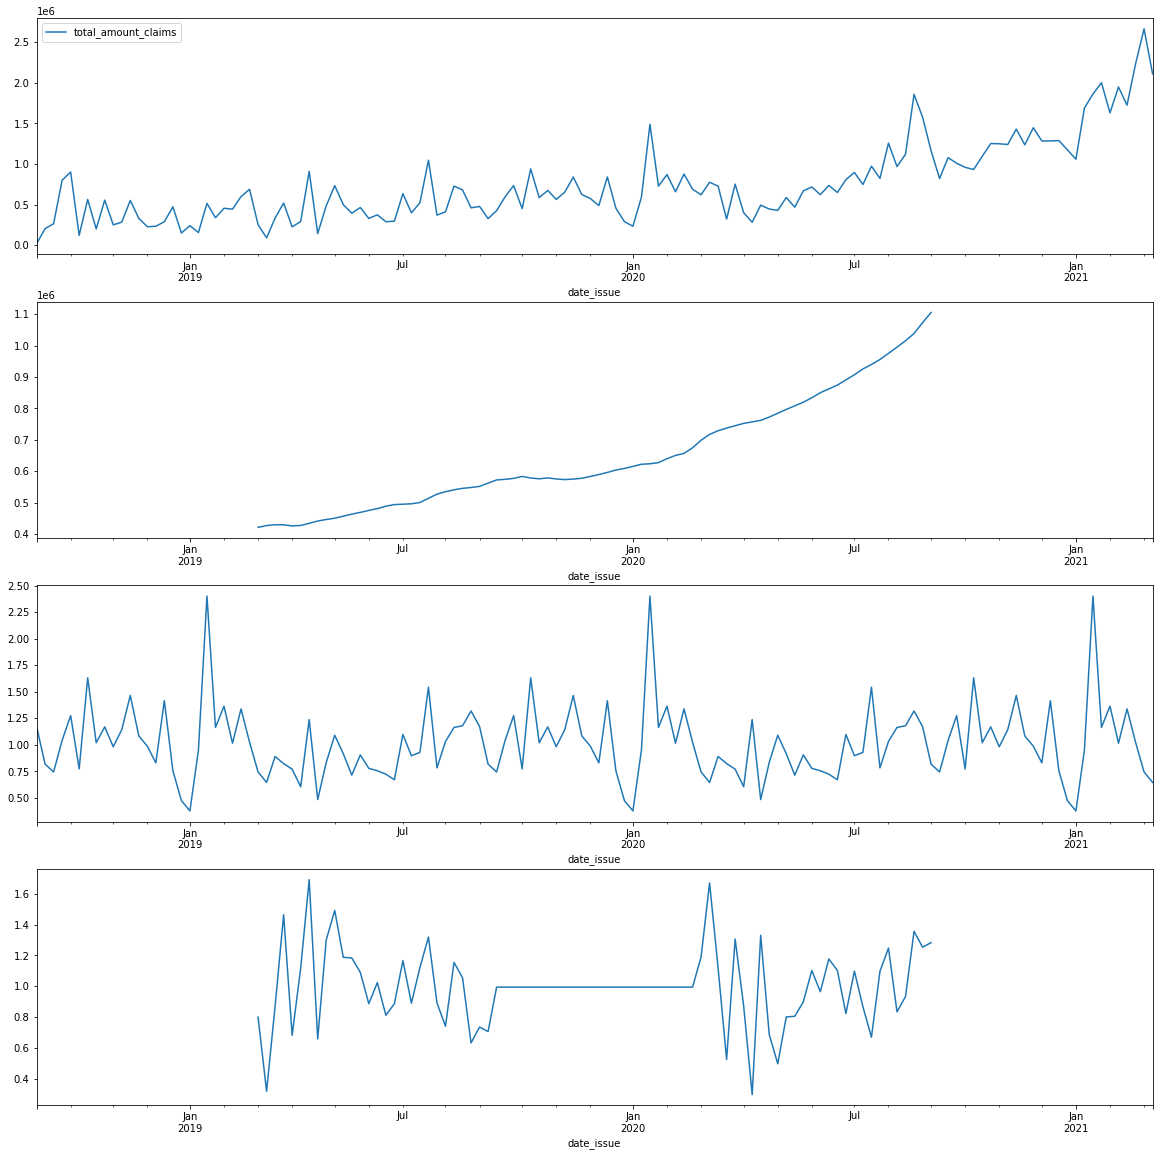

In [11]:
# Applying seasonal decompose

#First we try multiplicative
res_mul = seasonal_decompose(data_di, model='multiplicative')
plt.figure(figsize=(20,10))

fig, (ax1,ax2,ax3, ax4) = plt.subplots(4,1, figsize=(20,20))
data_di.plot(ax=ax1)
res_mul.trend.plot(ax=ax2)
res_mul.seasonal.plot(ax=ax3)
res_mul.resid.plot(ax=ax4)



<AxesSubplot:xlabel='date_issue'>

<Figure size 1440x720 with 0 Axes>

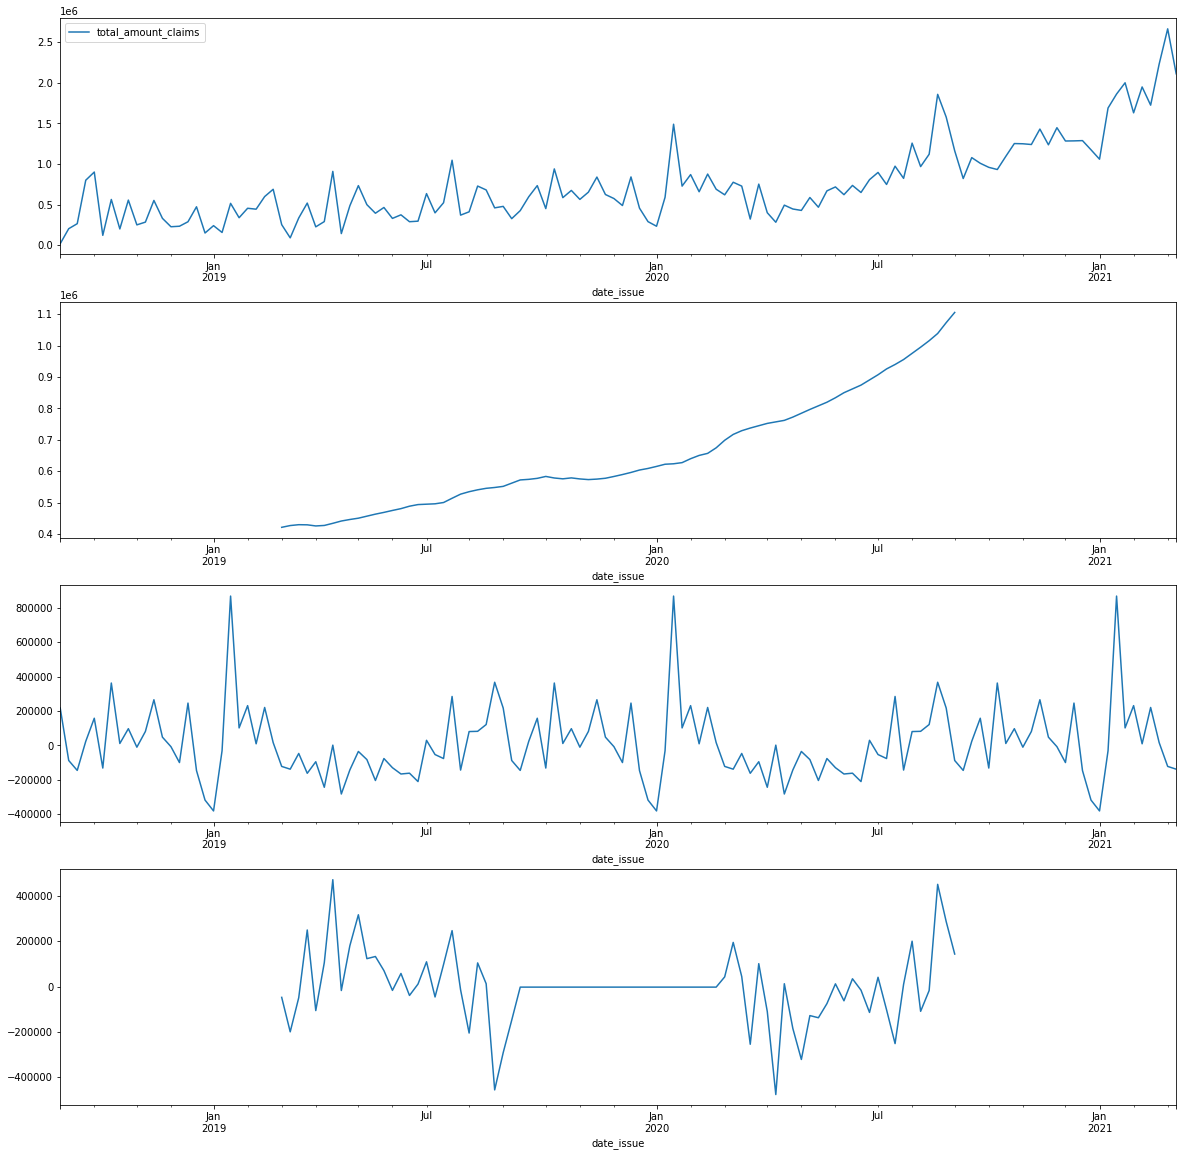

In [12]:
# Now we try additive
res_add = seasonal_decompose(data_di, model='additive')
plt.figure(figsize=(20,10))

fig, (ax1,ax2,ax3, ax4) = plt.subplots(4,1, figsize=(20,20))
data_di.plot(ax=ax1)
res_add.trend.plot(ax=ax2)
res_add.seasonal.plot(ax=ax3)
res_add.resid.plot(ax=ax4)


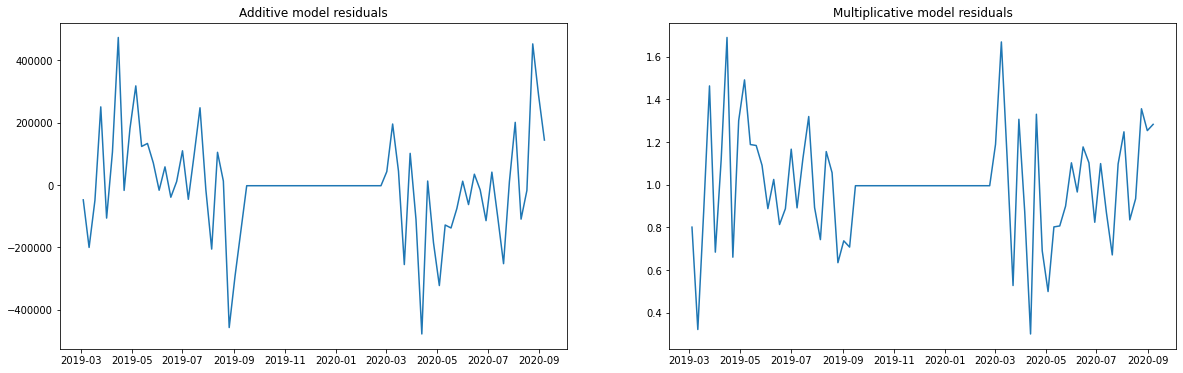

In [13]:
# Plot the residuals with "result_add.resid" to decide
f, (ax1, ax2) = plt.subplots(1,2, figsize=(20,6))
ax1.plot(res_add.resid); ax1.set_title("Additive model residuals")
ax2.plot(res_mul.resid); ax2.set_title("Multiplicative model residuals");

# Multiplicative seems better (residuals less dependent from time)

In [14]:
res_add.resid.isnull().sum()

52

In [15]:
# Checking stationarity in original data

pvalue_y = adfuller(data_di)[1]
pvalue_y
def stationary(pvalue):
    if pvalue < 0.05:
        print('TS is stationary')
    else:
        print('TS is not stationary')
stationary(pvalue_y), pvalue_y


TS is not stationary


(None, 0.9820064277979804)

In [16]:
# Checking stationarity in multiplicative decomposed serie
mul_resid_ts = res_mul.resid.dropna()
pvalue_y_mul = adfuller(mul_resid_ts)[1]
stationary(pvalue_y_mul), pvalue_y_mul

TS is stationary


(None, 0.013005491972087026)

In [17]:
# Checking stationarity in additive decomposed serie
add_resid_ts = res_add.resid.dropna()
pvalue_y_add = adfuller(add_resid_ts)[1]
stationary(pvalue_y_add), pvalue_y_add

TS is stationary


(None, 0.013592386018843048)

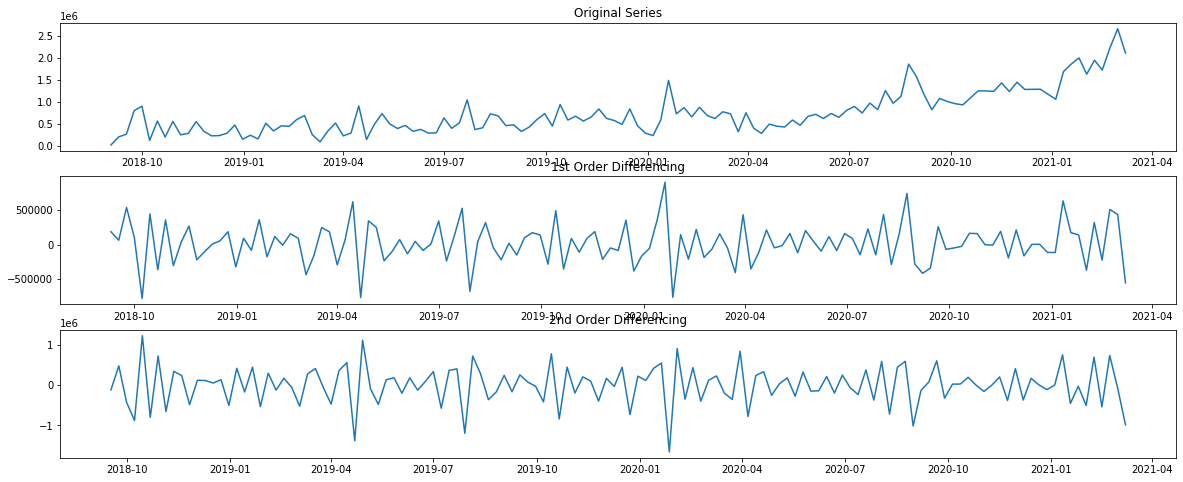

In [18]:
# Differencing original series (exploring)

data_di_diff_1 = data_di.diff(1).dropna()
data_di_diff_2 = data_di.diff(1).diff(1).dropna()
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(20,8))
ax1.plot(data_di); ax1.set_title('Original Series')
ax2.plot(data_di_diff_1); ax2.set_title('1st Order Differencing')
ax3.plot(data_di_diff_2); ax3.set_title('2nd Order Differencing');

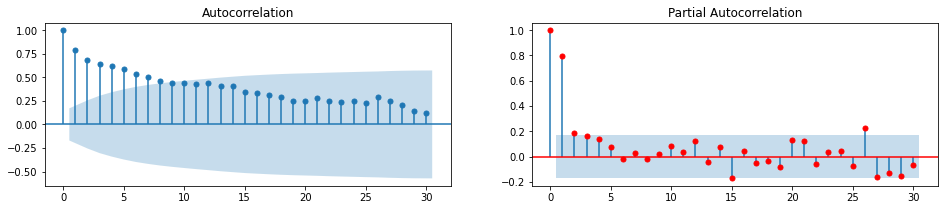

In [19]:
## ACF y PACF of original serie
fig, axes = plt.subplots(1,2, figsize=(16,3))
plot_acf(data_di, lags=30, ax=axes[0]);
plot_pacf(data_di, lags=30, ax=axes[1], color='r');

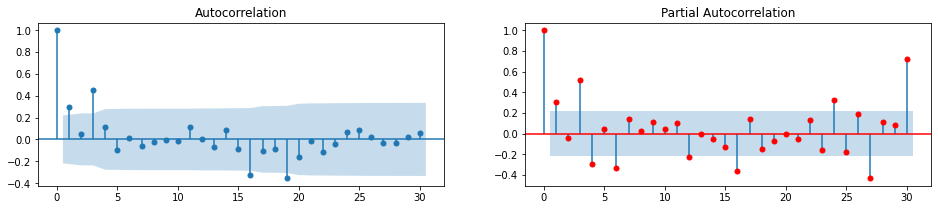

In [20]:
# Checking additive residuals ACF and PACF
fig, axes = plt.subplots(1,2, figsize=(16,3))
plot_acf(add_resid_ts, lags=30, ax=axes[0]);
plot_pacf(add_resid_ts, lags=30, ax=axes[1], color='r');

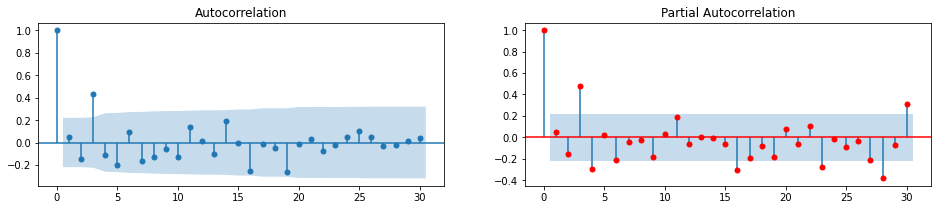

In [21]:
# Checking multiplicative residuals ACF and PACF
fig, axes = plt.subplots(1,2, figsize=(16,3))
plot_acf(mul_resid_ts, lags=30, ax=axes[0]);
plot_pacf(mul_resid_ts, lags=30, ax=axes[1], color='r');

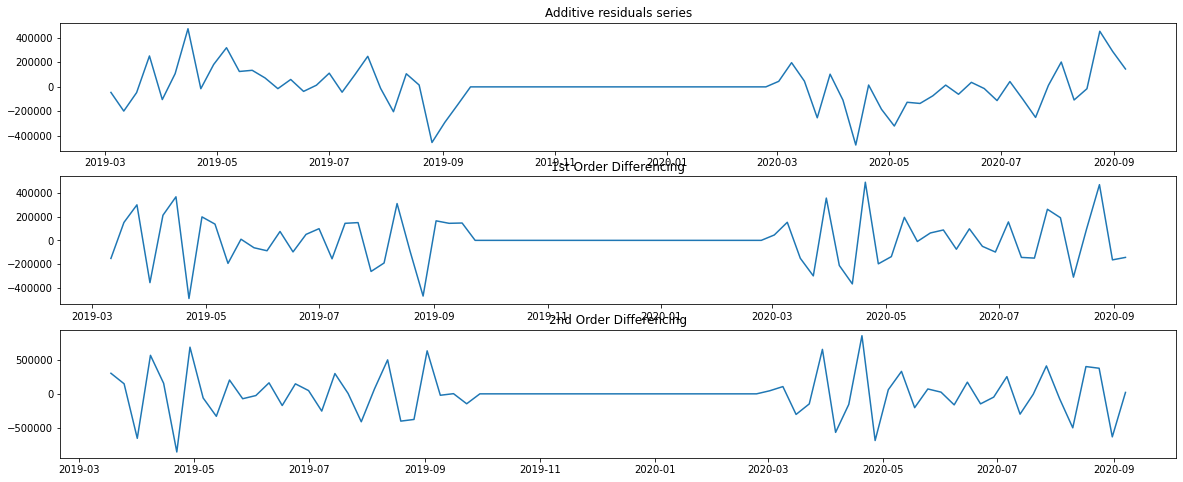

In [22]:
# Differencing additive residuals series
add_resid_ts_diff_1 = add_resid_ts.diff(1).dropna()
add_resid_ts_diff_2 = add_resid_ts.diff(1).diff(1).dropna()
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(20,8))
ax1.plot(add_resid_ts); ax1.set_title('Additive residuals series')
ax2.plot(add_resid_ts_diff_1); ax2.set_title('1st Order Differencing')
ax3.plot(add_resid_ts_diff_2); ax3.set_title('2nd Order Differencing');

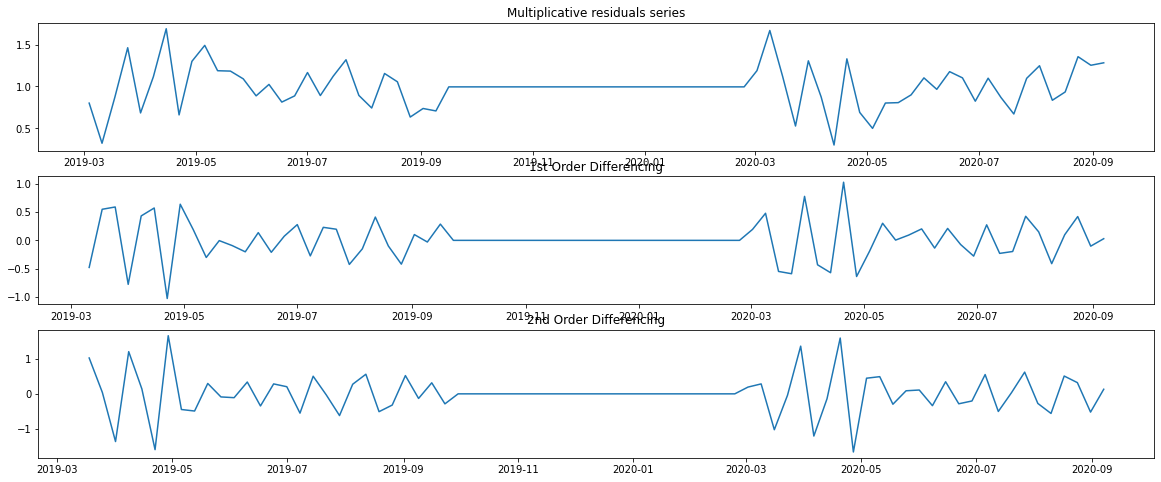

In [23]:
# Differencing multiplicative residuals series
mul_resid_ts_diff_1 = mul_resid_ts.diff(1).dropna()
mul_resid_ts_diff_2 = mul_resid_ts.diff(1).diff(1).dropna()
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(20,8))
ax1.plot(mul_resid_ts); ax1.set_title('Multiplicative residuals series')
ax2.plot(mul_resid_ts_diff_1); ax2.set_title('1st Order Differencing')
ax3.plot(mul_resid_ts_diff_2); ax3.set_title('2nd Order Differencing');

ValueError: Can only compute partial correlations for lags up to 50% of the sample size. The requested nlags 60 must be < 39.

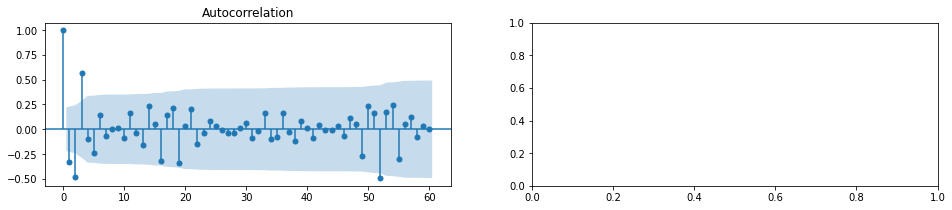

In [24]:
# Checking additive residuals diff 1 ACF and PACF
fig, axes = plt.subplots(1,2, figsize=(16,3))
plot_acf(add_resid_ts_diff_1, lags=60, ax=axes[0]);
plot_pacf(add_resid_ts_diff_1, lags=60, ax=axes[1], color='r');

In [ ]:
# Checking multiplicative residuals diff 1 ACF and PACF
fig, axes = plt.subplots(1,2, figsize=(16,3))
plot_acf(mul_resid_ts_diff_1, lags=60, ax=axes[0]);
plot_pacf(mul_resid_ts_diff_1, lags=60, ax=axes[1], color='r');

In [ ]:
# Splitting data
# Additive serie
split_1 = 0.7
split_index_1 = round(len(add_resid_ts)*split_1)

add_resid_ts_train = add_resid_ts.iloc[:split_index_1]
add_resid_ts_test = add_resid_ts.iloc[split_index_1:]

add_resid_ts_train.head(), add_resid_ts_train.tail(), add_resid_ts_test.head(), add_resid_ts_test.tail()


In [ ]:
# Splitting data
# Multiplicative serie

split_2 = 0.7
split_index_2 = round(len(mul_resid_ts)*split_2)
mul_resid_ts_train = mul_resid_ts.iloc[:split_index_2]
mul_resid_ts_test = mul_resid_ts.iloc[split_index_2:]

mul_resid_ts_train.head(), mul_resid_ts_train.tail(), mul_resid_ts_test.head(), mul_resid_ts_test.tail()

In [ ]:
# Trying Auto ARIMA with additive residuals serie
stepwise_fit_add = pm.auto_arima(add_resid_ts_train, start_p=0, start_q=0,
                             max_p=2, max_q=3, m=7,
                             start_P=0, seasonal=True,
                             d=1, D=1, trace=True,
                             error_action='ignore', # don’t want to know if an order does not work
                             suppress_warnings=True) # don’t want convergence warnings)
stepwise_fit_add.summary()

In [ ]:

# Trying Auto ARIMA with multiplicative residuals serie
stepwise_fit_mul = pm.auto_arima(mul_resid_ts_train, start_p=0, start_q=0,
                             max_p=2, max_q=3, m=7,
                             start_P=0, seasonal=True,
                             d=1, D=1, trace=True,
                             error_action='ignore', # don’t want to know if an order does not work
                             suppress_warnings=True) # don’t want convergence warnings)
stepwise_fit_mul.summary()


In [ ]:
# with m=12 AIC = 1954.975, Best Model = ARIMA(2,1,0)(2,1,0)[12] 
# with m=7 AIC =  1769.693, Best Model = ARIMA(2,1,0)(2,1,2)[7]
# with m=1 AIC = 1804.360, Best Model = ARIMA(2,1,0)(0,0,0)[0] 



In [ ]:
# We are choosing multiplicative decomposed serie with m=7 because it gives the lower AIC
# Let's predict


resid_pred_mul = stepwise_fit_mul.predict(n_periods=len(mul_resid_ts_test))

In [ ]:
resid_pred_mul

In [ ]:
pa = pd.DataFrame(mul_resid_ts_test)
pa['resid_pred_mul'] = resid_pred_mul
pa['absolute_error'] = abs(pa['resid'] - pa['resid_pred_mul'])
pa

In [ ]:
#Plotting residuals

plt.figure(figsize=(20,10))
plt.plot( 'resid', data= pa)
plt.plot( 'resid_pred_mul', data= pa)
plt.legend()

In [ ]:
# Plot predict with optimal model
# Build model
best_sarima = SARIMAX(mul_resid_ts_train, order=(2, 1, 0),seasonal_order=(2,1,2,7))
best_sarima = best_sarima.fit()

# Forecast
best_results = best_sarima.get_forecast(len(mul_resid_ts_test), alpha=0.05)
best_forecast = best_results.predicted_mean
best_confidence_int = best_results.conf_int()

In [ ]:
best_confidence_int

In [ ]:
# re-compose back to initial time series
best_forecast_recons = best_forecast*res_mul.seasonal[split_index_2:]*res_mul.trend[split_index_2:]
train_recons = mul_resid_ts_train*res_mul.seasonal[:split_index_2]*res_mul.trend[:split_index_2]
test_recons = mul_resid_ts_test*res_mul.seasonal[split_index_2:]*res_mul.trend[split_index_2:]
best_upper_recons = best_confidence_int['upper resid']*res_mul.seasonal[split_index_2:]*res_mul.trend[split_index_2:]
best_lower_recons = best_confidence_int['lower resid']*res_mul.seasonal[split_index_2:]*res_mul.trend[split_index_2:]

In [ ]:
def plot_forecast(fc, train, test, upper=None, lower=None):
    is_confidence_int = isinstance(upper, np.ndarray) and isinstance(lower, np.ndarray)
    # Prepare plot series
    fc_series = pd.Series(fc, index=test.index)
    lower_series = pd.Series(upper, index=test.index) if is_confidence_int else None
    upper_series = pd.Series(lower, index=test.index) if is_confidence_int else None
    # Plot
    plt.figure(figsize=(10,4), dpi=100)
    plt.plot(train, label='training', color='black')
    plt.plot(test, label='actual', color='black', ls='--')
    plt.plot(fc_series, label='forecast', color='orange')
    if is_confidence_int:
        plt.fill_between(lower_series.index, lower_series, upper_series, color='k', alpha=.15)
    plt.title('Forecast vs Actuals')
    plt.legend(loc='upper left', fontsize=8);

In [ ]:
# Plotting 
plot_forecast(best_forecast_recons, train_recons, test_recons, upper = best_upper_recons, lower=best_lower_recons)


In [ ]:
test_recons

In [ ]:
# computing mae
best_sarima_performance = pd.DataFrame(test_recons)
best_sarima_performance['best_forecast_recons'] = best_forecast_recons
best_sarima_performance.rename(columns={0: 'test_recons'}, inplace=True)

best_sarima_performance.dropna(inplace=True)

best_sarima_performance['absolute_error'] = abs(best_sarima_performance['test_recons'] - best_sarima_performance['best_forecast_recons'])
best_sarima_performance
best_sarima_performance['absolute_error'].mean()



### Changing Train/Test split to reduce prediction horizon.

In [ ]:
# Splitting data
# Multiplicative serie

split_2 = 0.93
split_index_2 = round(len(mul_resid_ts)*split_2)
mul_resid_ts_train = mul_resid_ts.iloc[:split_index_2]
mul_resid_ts_test = mul_resid_ts.iloc[split_index_2:]

mul_resid_ts_train.head(), mul_resid_ts_train.tail(), mul_resid_ts_test.head(), mul_resid_ts_test.tail()

In [ ]:
# Trying Auto ARIMA with multiplicative residuals serie
stepwise_fit_mul = pm.auto_arima(mul_resid_ts_train, start_p=0, start_q=0,
                             max_p=2, max_q=3, m=7,
                             start_P=0, seasonal=True,
                             d=1, D=1, trace=True,
                             error_action='ignore', # don’t want to know if an order does not work
                             suppress_warnings=True) # don’t want convergence warnings)
stepwise_fit_mul.summary()

In [ ]:
# Plot predict with optimal model
# Build model
best_sarima = SARIMAX(mul_resid_ts_train, order=(2, 1, 0),seasonal_order=(2,1,2,7))
best_sarima = best_sarima.fit()

# Forecast
best_results = best_sarima.get_forecast(len(mul_resid_ts_test), alpha=0.05)
best_forecast = best_results.predicted_meqdan
best_confidence_int = best_results.conf_int()

In [ ]:
# re-compose back to initial time series
best_forecast_recons = best_forecast*res_mul.seasonal[split_index_2:]*res_mul.trend[split_index_2:]
train_recons = mul_resid_ts_train*res_mul.seasonal[:split_index_2]*res_mul.trend[:split_index_2]
test_recons = mul_resid_ts_test*res_mul.seasonal[split_index_2:]*res_mul.trend[split_index_2:]
best_upper_recons = best_confidence_int['upper resid']*res_mul.seasonal[split_index_2:]*res_mul.trend[split_index_2:]
best_lower_recons = best_confidence_int['lower resid']*res_mul.seasonal[split_index_2:]*res_mul.trend[split_index_2:]

In [ ]:
# Plotting 
plot_forecast(best_forecast_recons, train_recons, test_recons, upper = best_upper_recons, lower=best_lower_recons)


In [ ]:
# computing mae
best_sarima_performance = pd.DataFrame(test_recons)
best_sarima_performance['best_forecast_recons'] = best_forecast_recons
best_sarima_performance.rename(columns={0: 'test_recons'}, inplace=True)

best_sarima_performance.dropna(inplace=True)

best_sarima_performance['absolute_error'] = abs(best_sarima_performance['test_recons'] - best_sarima_performance['best_forecast_recons'])
best_sarima_performance
best_sarima_performance['absolute_error'].mean()



In [ ]:
# Reducing test split does not improve performance

### Additional analysis made with Tomi

In [ ]:


# Differencing additive residuals series by 7 since there seems to be weekly seasonality
add_resid_ts_diff_7 = add_resid_ts.diff(7).dropna()
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(20,8))
ax1.plot(add_resid_ts); ax1.set_title('Additive residuals series')
ax2.plot(add_resid_ts_diff_7); ax2.set_title('7th Order Differencing')


In [ ]:
# Checking additive residuals diff 7 ACF and PACF
fig, axes = plt.subplots(1,2, figsize=(16,3))
plot_acf(add_resid_ts_diff_7, lags=60, ax=axes[0]);
plot_pacf(add_resid_ts_diff_7, lags=60, ax=axes[1], color='r');

### Checking forecast with raw data (w/ Renan)

In [ ]:
# Splitting data
# raw serie
split = 0.7
split_index = round(len(data_di)*split)
raw_train = data_di.iloc[:split_index]
raw_test = data_di.iloc[split_index:]


In [ ]:
# Trying Auto ARIMA with raw data
stepwise_fit_raw = pm.auto_arima(raw_train, start_p=0, start_q=0,
                             max_p=2, max_q=3, m=7,
                             start_P=0, seasonal=True,
                             d=1, D=1, trace=True,
                             error_action='ignore', # don’t want to know if an order does not work
                             suppress_warnings=True) # don’t want convergence warnings)
stepwise_fit_raw.summary()

In [ ]:
# m=1, AIC = 16354.856, Best model:  ARIMA(2,1,3)(0,0,0)[0]
# m=7, AIC = 16298.906, Best model:  ARIMA(0,1,2)(0,1,1)[7] 

In [ ]:
# Build model
sarima = SARIMAX(raw_train, order=(2, 1, 0),seasonal_order=(2,1,2,7))
sarima = sarima.fit()

# Forecast
results = sarima.get_forecast(len(raw_test), alpha=0.05)
forecast = results.predicted_mean
confidence_int = results.conf_int()

In [ ]:
confidence_int

In [25]:
# Plotting

plot_forecast(forecast, raw_train, raw_test, upper = confidence_int['upper total_amount_claims'], lower=confidence_int['lower total_amount_claims'])


NameError: name 'plot_forecast' is not defined

### A new approach to remove stationality since seasonal decompose removes a lot of data

In [26]:
def plot_forecast(fc, train, test, upper=None, lower=None):
    is_confidence_int = isinstance(upper, np.ndarray) and isinstance(lower, np.ndarray)
    # Prepare plot series
    fc_series = pd.Series(fc, index=test.index)
    lower_series = pd.Series(upper, index=test.index) if is_confidence_int else None
    upper_series = pd.Series(lower, index=test.index) if is_confidence_int else None
    # Plot
    plt.figure(figsize=(10,4), dpi=100)
    plt.plot(train, label='training', color='black')
    plt.plot(test, label='actual', color='black', ls='--')
    plt.plot(fc_series, label='forecast', color='orange')
    if is_confidence_int:
        plt.fill_between(lower_series.index, lower_series, upper_series, color='k', alpha=.15)
    plt.title('Forecast vs Actuals')
    plt.legend(loc='upper left', fontsize=8);

<AxesSubplot:xlabel='date_issue'>

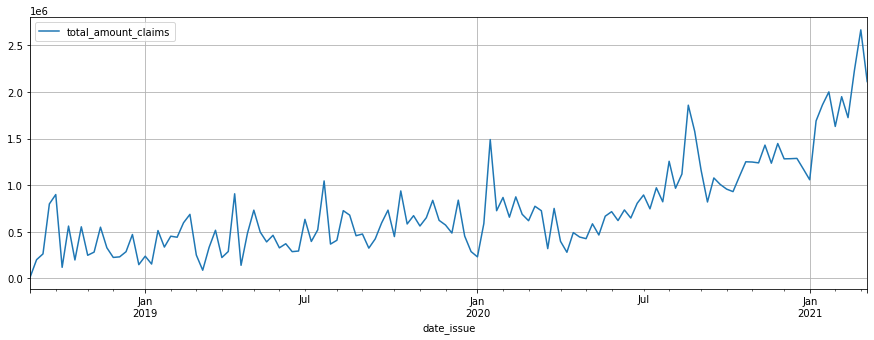

In [65]:
data_di.plot(grid=True, figsize=(15,5))

<AxesSubplot:xlabel='date_issue'>

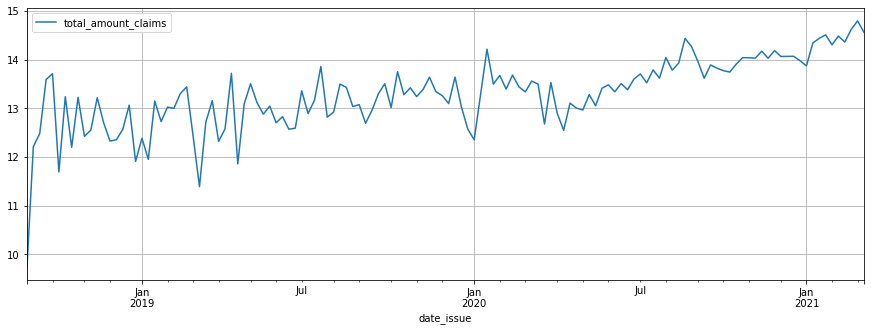

In [27]:
detrended = np.log(data_di)
detrended.plot(grid=True, figsize=(15,5))

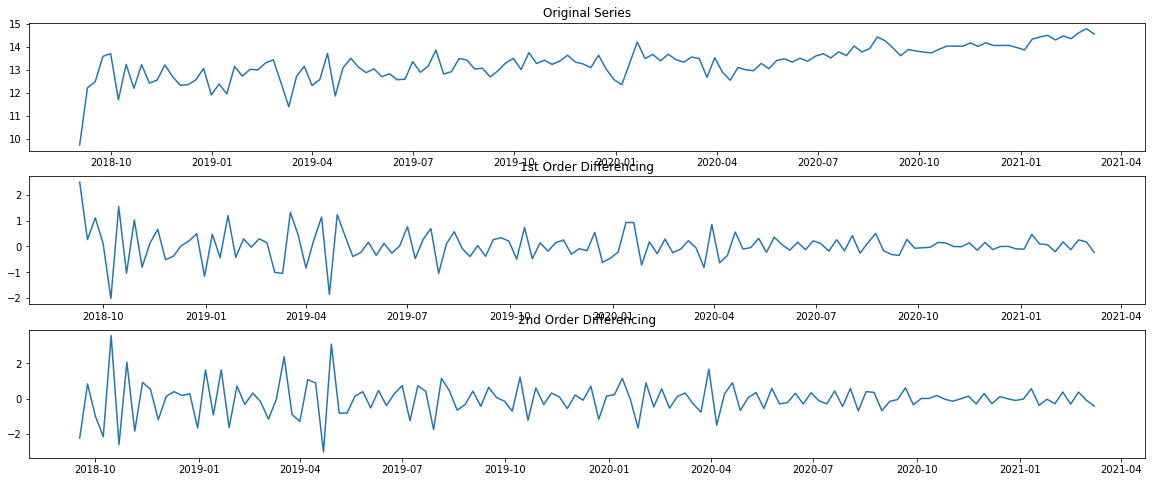

In [28]:
# Differencing detrended series (exploring)

detrended_diff_1 = detrended.diff(1).dropna()
detrended_diff_2 = detrended.diff(1).diff(1).dropna()
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(20,8))
ax1.plot(detrended); ax1.set_title('Original Series')
ax2.plot(detrended_diff_1); ax2.set_title('1st Order Differencing')
ax3.plot(detrended_diff_2); ax3.set_title('2nd Order Differencing');

In [29]:
pvalue_y = adfuller(detrended_diff_1)[1]
pvalue_y
def stationary(pvalue):
    if pvalue < 0.05:
        print('TS is stationary')
    else:
        print('TS is not stationary')
stationary(pvalue_y), pvalue_y


TS is stationary


(None, 0.0002590318144858786)

In [30]:
# Serie is stationary when d=1

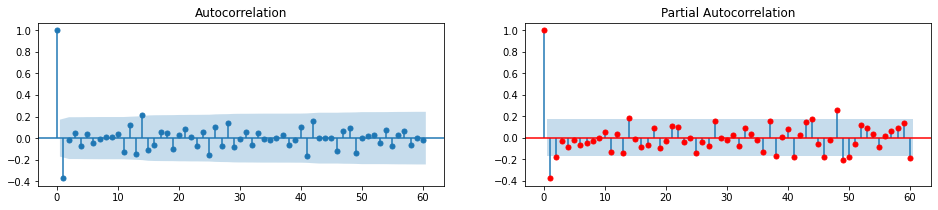

In [31]:
# Checking additive residuals detrended dif 1
fig, axes = plt.subplots(1,2, figsize=(16,3))
plot_acf(detrended_diff_1, lags=60, ax=axes[0]);
plot_pacf(detrended_diff_1, lags=60, ax=axes[1], color='r');

In [32]:
# ARIMA 1,1,1 should be a good starting point. Max values for Auto ARIMA are 2,2

In [33]:
# Splitting data
split = 0.7
split_index = round(len(detrended)*split)
detrended_train = detrended.iloc[:split_index]
detrended_test = detrended.iloc[split_index:]

In [34]:
# Trying Auto ARIMA with detrended data
stepwise_fit_detrended = pm.auto_arima(detrended_train, start_p=0, start_q=0,
                             max_p=2, max_q=2, m=1,
                             start_P=0, seasonal=False,
                             d=1, D=1, trace=True,
                             error_action='ignore', # don’t want to know if an order does not work
                             suppress_warnings=True) # don’t want convergence warnings)
stepwise_fit_detrended.summary()

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=195.377, Time=0.13 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=181.343, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.07 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=193.701, Time=0.01 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=178.088, Time=0.03 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.15 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.11 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=176.699, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=179.845, Time=0.01 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=166.641, Time=0.04 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=164.664, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=163.323, Time=0.02 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=164.654, Time=0.03 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=166.595, Time=0.05 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0]          
Total fit ti

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                   92
Model:               SARIMAX(0, 1, 1)   Log Likelihood                 -79.661
Date:                Wed, 10 Mar 2021   AIC                            163.323
Time:                        17:36:44   BIC                            168.344
Sample:                             0   HQIC                           165.349
                                 - 92                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.8924      0.080    -11.182      0.000      -1.049      -0.736
sigma2         0.3314      0.039      8.438      0.000       0.254       0.408
===================================================================================
Ljung-Box (L1) (Q):                   3.84   Jarque-Bera (JB):                12.39
Prob(Q):                              0.05   Prob(JB):                         0.00
Heteroskedasticity (H):               0.25   Skew:                             0.56
Prob(H) (two-sided):                  0.00   Kurtosis:                         4.43
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [35]:
# Build best model
sarima = SARIMAX(detrended_train, order=(0, 1, 1),seasonal_order=(0,0,0,0))
sarima = sarima.fit()

# Forecast
results = sarima.get_forecast(len(detrended_test), alpha=0.05)
forecast = results.predicted_mean
confidence_int = results.conf_int()



/Users/santiagochiesa/.pyenv/versions/3.8.6/envs/Insurance_claiming_forecasting/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  warnings.warn('No frequency information was'
/Users/santiagochiesa/.pyenv/versions/3.8.6/envs/Insurance_claiming_forecasting/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  warnings.warn('No frequency information was'


In [36]:
forecast

2020-06-08    13.217936
2020-06-15    13.217936
2020-06-22    13.217936
2020-06-29    13.217936
2020-07-06    13.217936
2020-07-13    13.217936
2020-07-20    13.217936
2020-07-27    13.217936
2020-08-03    13.217936
2020-08-10    13.217936
2020-08-17    13.217936
2020-08-24    13.217936
2020-08-31    13.217936
2020-09-07    13.217936
2020-09-14    13.217936
2020-09-21    13.217936
2020-09-28    13.217936
2020-10-05    13.217936
2020-10-12    13.217936
2020-10-19    13.217936
2020-10-26    13.217936
2020-11-02    13.217936
2020-11-09    13.217936
2020-11-16    13.217936
2020-11-23    13.217936
2020-11-30    13.217936
2020-12-07    13.217936
2020-12-14    13.217936
2020-12-21    13.217936
2020-12-28    13.217936
2021-01-04    13.217936
2021-01-11    13.217936
2021-01-18    13.217936
2021-01-25    13.217936
2021-02-01    13.217936
2021-02-08    13.217936
2021-02-15    13.217936
2021-02-22    13.217936
2021-03-01    13.217936
2021-03-08    13.217936
Freq: W-MON, Name: predicted_mean, dtype

In [37]:
# Build Model
arima = ARIMA(detrended_train, order=(0, 1, 1))  
arima = arima.fit()
# Forecast
forecast_arima, std_err_arima, confidence_int_arima = arima.forecast(len(detrended_test), alpha=0.05)  # 95% confidence

/Users/santiagochiesa/.pyenv/versions/3.8.6/envs/Insurance_claiming_forecasting/lib/python3.8/site-packages/statsmodels/tsa/arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)
/Users/santiagochiesa/.pyenv/versions/3.8.6/envs/Insurance_claiming_forecasting/lib/python3.8/sit

In [38]:
arima.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               ARIMA Model Results                               
=================================================================================
Dep. Variable:     D.total_amount_claims   No. Observations:                   91
Model:                    ARIMA(0, 1, 1)   Log Likelihood                 -77.260
Method:                          css-mle   S.D. of innovations              0.552
Date:                   Wed, 10 Mar 2021   AIC                            160.520
Time:                           17:36:45   BIC                            168.052
Sample:                       09-10-2018   HQIC                           163.559
                            - 06-01-2020                                         
===============================================================================================
                                  coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
const                           0.0108      0.002      4.968      0.000       0.007       0.015
ma.L1.D.total_amount_claims    -0.9999      0.043    -23.342      0.000      -1.084      -0.916
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
MA.1            1.0001           +0.0000j            1.0001            0.0000
-----------------------------------------------------------------------------
"""

In [39]:
forecast_arima

array([13.47611854, 13.48687767, 13.49763681, 13.50839594, 13.51915508,
       13.52991421, 13.54067334, 13.55143248, 13.56219161, 13.57295074,
       13.58370988, 13.59446901, 13.60522815, 13.61598728, 13.62674641,
       13.63750555, 13.64826468, 13.65902381, 13.66978295, 13.68054208,
       13.69130122, 13.70206035, 13.71281948, 13.72357862, 13.73433775,
       13.74509688, 13.75585602, 13.76661515, 13.77737429, 13.78813342,
       13.79889255, 13.80965169, 13.82041082, 13.83116995, 13.84192909,
       13.85268822, 13.86344736, 13.87420649, 13.88496562, 13.89572476])

In [40]:
confidence_int_arima

array([[12.39480241, 14.55743467],
       [12.40556154, 14.5681938 ],
       [12.41632068, 14.57895294],
       [12.42707981, 14.58971207],
       [12.43783894, 14.60047121],
       [12.44859807, 14.61123035],
       [12.4593572 , 14.62198948],
       [12.47011634, 14.63274862],
       [12.48087547, 14.64350775],
       [12.4916346 , 14.65426689],
       [12.50239373, 14.66502602],
       [12.51315287, 14.67578516],
       [12.523912  , 14.68654429],
       [12.53467113, 14.69730343],
       [12.54543026, 14.70806256],
       [12.55618939, 14.7188217 ],
       [12.56694853, 14.72958083],
       [12.57770766, 14.74033997],
       [12.58846679, 14.75109911],
       [12.59922592, 14.76185824],
       [12.60998505, 14.77261738],
       [12.62074419, 14.78337651],
       [12.63150332, 14.79413565],
       [12.64226245, 14.80489478],
       [12.65302158, 14.81565392],
       [12.66378072, 14.82641305],
       [12.67453985, 14.83717219],
       [12.68529898, 14.84793132],
       [12.69605811,

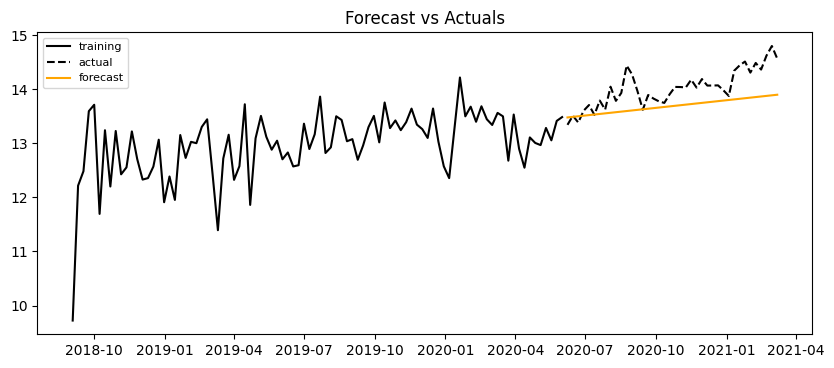

In [41]:
plot_forecast(forecast_arima, detrended_train, detrended_test)

In [42]:

# re-compose back to initial time series

forecast_recons = np.exp(forecast_arima)
train_recons = np.exp(detrended_train)
test_recons = np.exp(detrended_test)
# lower_recons = np.exp(confidence_int['lower total_amount_claims'])
# upper_recons = np.exp(confidence_int['upper total_amount_claims'])

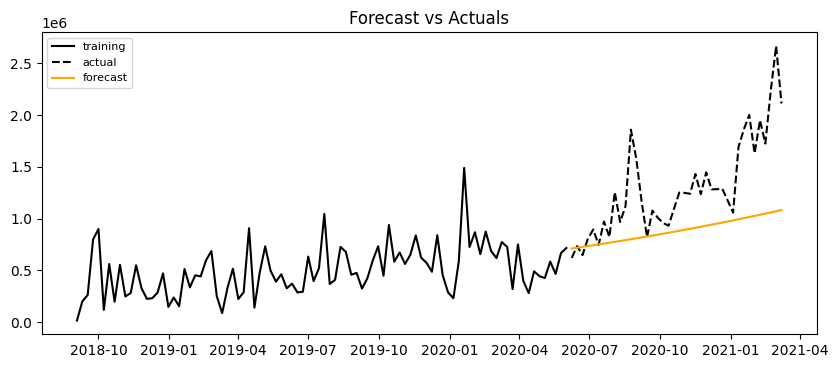

In [43]:
# Plotting
plot_forecast(forecast_recons, train_recons, test_recons)


In [44]:
test_recons

,total_amount_claims
date_issue,
2020-06-08,621283.0
2020-06-15,735286.0
2020-06-22,648367.0
2020-06-29,806380.0
2020-07-06,895589.0
2020-07-13,747161.0
2020-07-20,972735.0
2020-07-27,822597.0
2020-08-03,1256998.0


In [45]:
# computing mae
arima_performance = pd.DataFrame(test_recons)
arima_performance['forecast_recons'] = forecast_recons


# arima_performance.dropna(inplace=True)

arima_performance['absolute_error'] = abs(arima_performance['total_amount_claims'] - arima_performance['forecast_recons'])
arima_performance
arima_performance['absolute_error'].mean()


421391.4220227614

### Training other ARIMA 

In [46]:
# Build Model
arima = ARIMA(detrended_train, order=(2, 1, 0))  
arima = arima.fit()
# Forecast
forecast_arima, std_err_arima, confidence_int_arima = arima.forecast(len(detrended_test), alpha=0.05)  # 95% confidence

/Users/santiagochiesa/.pyenv/versions/3.8.6/envs/Insurance_claiming_forecasting/lib/python3.8/site-packages/statsmodels/tsa/arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)
/Users/santiagochiesa/.pyenv/versions/3.8.6/envs/Insurance_claiming_forecasting/lib/python3.8/sit

In [47]:
arima.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               ARIMA Model Results                               
=================================================================================
Dep. Variable:     D.total_amount_claims   No. Observations:                   91
Model:                    ARIMA(2, 1, 0)   Log Likelihood                 -85.044
Method:                          css-mle   S.D. of innovations              0.615
Date:                   Wed, 10 Mar 2021   AIC                            178.087
Time:                           17:36:45   BIC                            188.131
Sample:                       09-10-2018   HQIC                           182.139
                            - 06-01-2020                                         
===============================================================================================
                                  coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
const                           0.0281      0.036      0.782      0.434      -0.042       0.099
ar.L1.D.total_amount_claims    -0.5489      0.112     -4.905      0.000      -0.768      -0.330
ar.L2.D.total_amount_claims    -0.2592      0.111     -2.331      0.020      -0.477      -0.041
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1           -1.0589           -1.6544j            1.9642           -0.3406
AR.2           -1.0589           +1.6544j            1.9642            0.3406
-----------------------------------------------------------------------------
"""

In [48]:
confidence_int_arima = pd.DataFrame(confidence_int_arima, columns=['lower', 'upper'])

In [49]:
forecast_arima

array([13.40172252, 13.47871969, 13.50823685, 13.52290873, 13.55803551,
       13.58578206, 13.61227807, 13.64137337, 13.66936601, 13.69729021,
       13.72553778, 13.75362558, 13.78171727, 13.80984824, 13.83795663,
       13.86606724, 13.89418248, 13.92229461, 13.95040724, 13.97852041,
       14.00663315, 14.03474598, 14.06285888, 14.09097171, 14.11908457,
       14.14719742, 14.17531028, 14.20342313, 14.23153598, 14.25964884,
       14.28776169, 14.31587455, 14.3439874 , 14.37210025, 14.40021311,
       14.42832596, 14.45643882, 14.48455167, 14.51266452, 14.54077738])

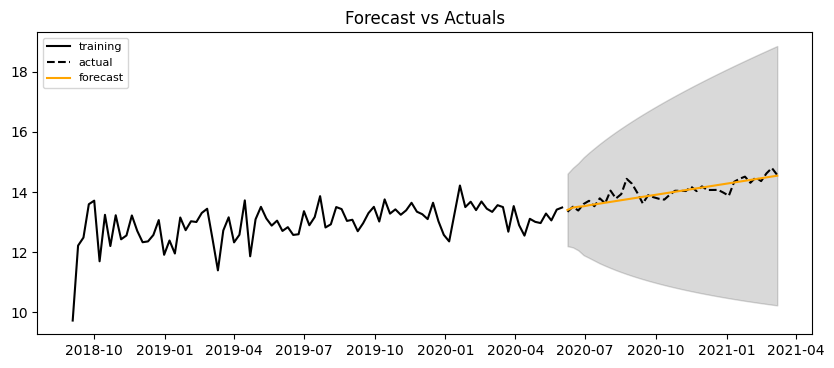

In [57]:
plot_forecast(forecast_arima, detrended_train, detrended_test, upper= confidence_int_arima['upper'].values, lower= confidence_int_arima['lower'].values)





In [52]:
# re-compose back to initial time series

forecast_recons = np.exp(forecast_arima)
train_recons = np.exp(detrended_train)
test_recons = np.exp(detrended_test)
lower_recons = np.exp(confidence_int_arima)['lower']
upper_recons = np.exp(confidence_int_arima)['upper']

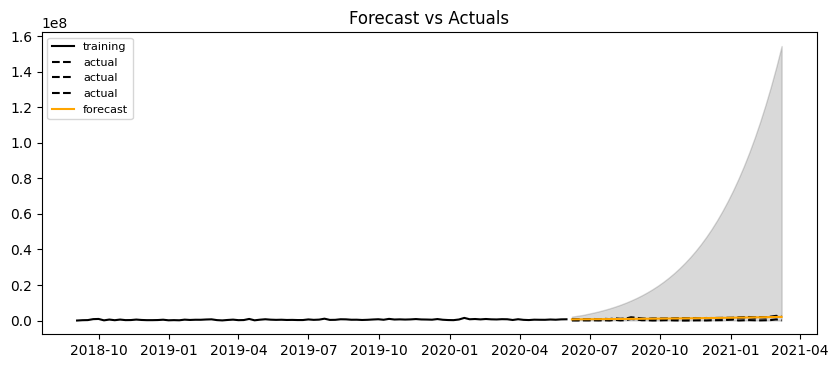

In [64]:
plot_forecast(forecast_recons, train_recons, test_recons, upper= upper_recons.values, lower= lower_recons.values)

In [61]:
confidence_int_arima['upper'], np.exp(confidence_int_arima)['upper']

(0     14.606882
 1     14.800819
 2     14.957806
 3     15.149524
 4     15.308238
 5     15.456038
 6     15.600899
 7     15.737702
 8     15.868913
 9     15.995955
 10    16.118754
 11    16.237915
 12    16.353907
 13    16.466978
 14    16.577410
 15    16.685446
 16    16.791276
 17    16.895075
 18    16.996995
 19    17.097168
 20    17.195713
 21    17.292736
 22    17.388331
 23    17.482584
 24    17.575572
 25    17.667364
 26    17.758025
 27    17.847612
 28    17.936179
 29    18.023775
 30    18.110446
 31    18.196233
 32    18.281176
 33    18.365310
 34    18.448668
 35    18.531283
 36    18.613184
 37    18.694397
 38    18.774948
 39    18.854863
 Name: upper, dtype: float64,
 0     2.206421e+06
 1     2.678639e+06
 2     3.133953e+06
 3     3.796249e+06
 4     4.449213e+06
 5     5.157891e+06
 6     5.961895e+06
 7     6.835920e+06
 8     7.794377e+06
 9     8.850240e+06
 10    1.000658e+07
 11    1.127294e+07
 12    1.265936e+07
 13    1.417482e+07
 14    1.5

In [55]:
forecast_arima, forecast_recons

(array([13.40172252, 13.47871969, 13.50823685, 13.52290873, 13.55803551,
        13.58578206, 13.61227807, 13.64137337, 13.66936601, 13.69729021,
        13.72553778, 13.75362558, 13.78171727, 13.80984824, 13.83795663,
        13.86606724, 13.89418248, 13.92229461, 13.95040724, 13.97852041,
        14.00663315, 14.03474598, 14.06285888, 14.09097171, 14.11908457,
        14.14719742, 14.17531028, 14.20342313, 14.23153598, 14.25964884,
        14.28776169, 14.31587455, 14.3439874 , 14.37210025, 14.40021311,
        14.42832596, 14.45643882, 14.48455167, 14.51266452, 14.54077738]),
 array([ 661141.07191983,  714058.15817106,  735449.27660197,
         746319.24638318,  773000.9145395 ,  794749.34610874,
         816088.48803042,  840181.62471344,  864032.79940856,
         888500.25466642,  913956.06158511,  939991.00265754,
         966771.3280999 ,  994353.67779716, 1022699.88461783,
        1051856.48246814, 1081849.335451  , 1112693.94209795,
        1144418.54211582, 1177048.28085582

In [56]:
upper_recons

0     2.206421e+06
1     2.678639e+06
2     3.133953e+06
3     3.796249e+06
4     4.449213e+06
5     5.157891e+06
6     5.961895e+06
7     6.835920e+06
8     7.794377e+06
9     8.850240e+06
10    1.000658e+07
11    1.127294e+07
12    1.265936e+07
13    1.417482e+07
14    1.582988e+07
15    1.763588e+07
16    1.960463e+07
17    2.174893e+07
18    2.408247e+07
19    2.661985e+07
20    2.937672e+07
21    3.236978e+07
22    3.561692e+07
23    3.913721e+07
24    4.295106e+07
25    4.708024e+07
26    5.154803e+07
27    5.637924e+07
28    6.160039e+07
29    6.723975e+07
30    7.332748e+07
31    7.989576e+07
32    8.697888e+07
33    9.461340e+07
34    1.028383e+08
35    1.116951e+08
36    1.212280e+08
37    1.314841e+08
38    1.425137e+08
39    1.543700e+08
Name: upper, dtype: float64

In [ ]:
# Plotting
plot_forecast(forecast_recons, train_recons, test_recons, upper= upper_recons.values, lower= lower_recons.values)

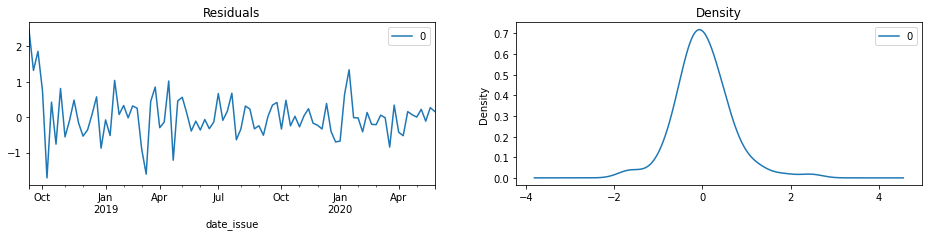

In [62]:
# Inference validity checking residuals of our model

residuals = pd.DataFrame(arima.resid)
fig, ax = plt.subplots(1,2, figsize=(16,3))
residuals.plot(title="Residuals", ax=ax[0])
residuals.plot(kind='kde', title='Density', ax=ax[1]);

In [63]:
# computing mae
arima_performance = pd.DataFrame(test_recons)
arima_performance['forecast_recons'] = forecast_recons


# arima_performance.dropna(inplace=True)

arima_performance['absolute_error'] = abs(arima_performance['total_amount_claims'] - arima_performance['forecast_recons'])
arima_performance
arima_performance['absolute_error'].mean()

185954.739654224

In [ ]:
# Model has poor performance

### New approach: applying diff to raw data

In [66]:
# Differencing additive residuals series
data_di_diff_1 = data_di.diff(1).dropna()

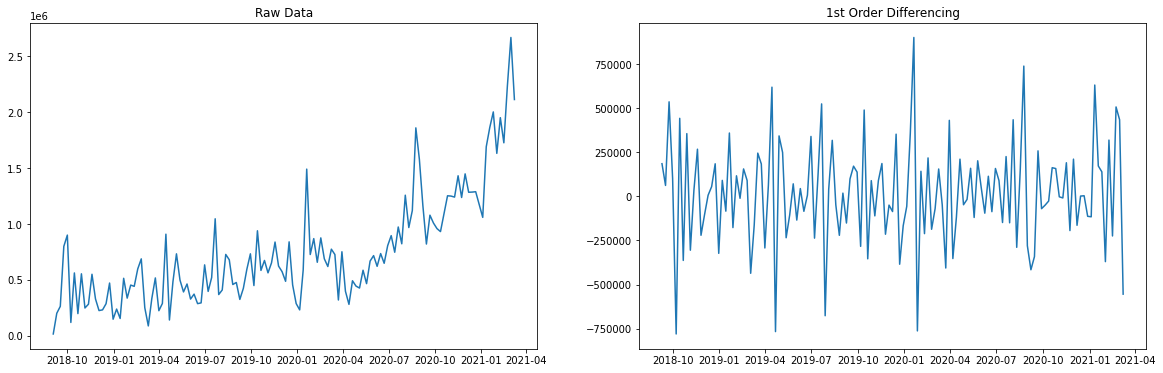

In [67]:
# Plotting
f, (ax1, ax2) = plt.subplots(1,2, figsize=(20,6))
ax1.plot(data_di); ax1.set_title("Raw Data")
ax2.plot(data_di_diff_1); ax2.set_title("1st Order Differencing");

In [68]:
pvalue_y = adfuller(data_di_diff_1)[1]
pvalue_y
def stationary(pvalue):
    if pvalue < 0.05:
        print('TS is stationary')
    else:
        print('TS is not stationary')
stationary(pvalue_y), pvalue_y


TS is stationary


(None, 1.1405478998684575e-17)

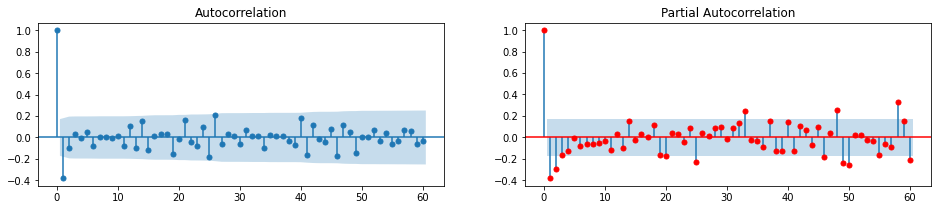

In [69]:
# Checking additive residuals detrended dif 1
fig, axes = plt.subplots(1,2, figsize=(16,3))
plot_acf(data_di_diff_1, lags=60, ax=axes[0]);
plot_pacf(data_di_diff_1, lags=60, ax=axes[1], color='r');

In [70]:
# Splitting data
split = 0.7
split_index = round(len(data_di)*split)
train = data_di.iloc[:split_index]
test = data_di.iloc[split_index:]

In [71]:
# Running ARIMA with d=1, p=2, q=1
# Build Model
arima = ARIMA(train, order=(2, 1, 1))  
arima = arima.fit()
# Forecast
forecast_arima, std_err_arima, confidence_int_arima = arima.forecast(len(detrended_test), alpha=0.05)  # 95% confidence

/Users/santiagochiesa/.pyenv/versions/3.8.6/envs/Insurance_claiming_forecasting/lib/python3.8/site-packages/statsmodels/tsa/arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)
/Users/santiagochiesa/.pyenv/versions/3.8.6/envs/Insurance_claiming_forecasting/lib/python3.8/sit

In [72]:
arima.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               ARIMA Model Results                               
=================================================================================
Dep. Variable:     D.total_amount_claims   No. Observations:                   91
Model:                    ARIMA(2, 1, 1)   Log Likelihood               -1250.937
Method:                          css-mle   S.D. of innovations         220559.509
Date:                   Wed, 10 Mar 2021   AIC                           2511.873
Time:                           18:20:22   BIC                           2524.427
Sample:                       09-10-2018   HQIC                          2516.938
                            - 06-01-2020                                         
===============================================================================================
                                  coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
const                        3807.0829    966.298      3.940      0.000    1913.174    5700.991
ar.L1.D.total_amount_claims     0.1103      0.106      1.040      0.298      -0.097       0.318
ar.L2.D.total_amount_claims    -0.0043      0.106     -0.040      0.968      -0.211       0.203
ma.L1.D.total_amount_claims    -1.0000      0.036    -27.942      0.000      -1.070      -0.930
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1           12.8919           -8.2252j           15.2923           -0.0904
AR.2           12.8919           +8.2252j           15.2923            0.0904
MA.1            1.0000           +0.0000j            1.0000            0.0000
-----------------------------------------------------------------------------
"""

In [73]:
confidence_int_arima = pd.DataFrame(confidence_int_arima, columns=['lower', 'upper'])

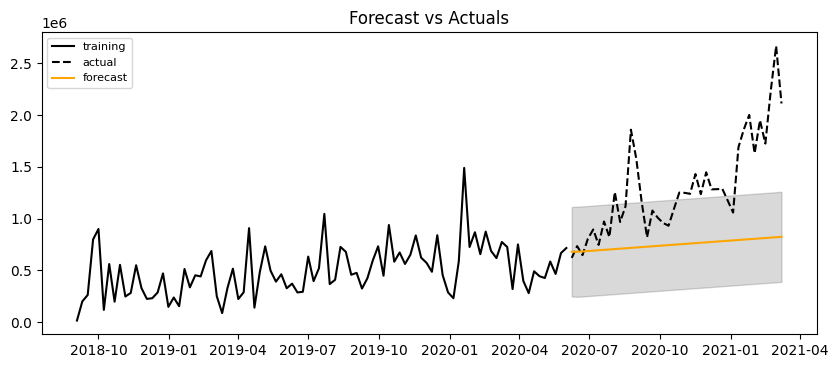

In [74]:
plot_forecast(forecast_arima, train, test, upper= confidence_int_arima['upper'].values, lower= confidence_int_arima['lower'].values)
